In [1]:
import os, sys, shutil, random
HOME = os.getcwd()
import numpy as np
from IPython.display import display, Image
from IPython import display
import yaml
import glob
import cv2
import utils
from ultralytics import YOLO
from IPython.display import display, Image
from IPython import display
display.clear_output()
display.clear_output()
!yolo checks

Ultralytics YOLOv8.2.70 🚀 Python-3.8.10 torch-2.2.1+cu121 CUDA:0 (Quadro RTX 8000, 48585MiB)
Setup complete ✅ (72 CPUs, 250.5 GB RAM, 465.1/1876.2 GB disk)

OS                  Linux-5.15.0-113-generic-x86_64-with-glibc2.29
Environment         Linux
Python              3.8.10
Install             git
RAM                 250.54 GB
CPU                 Intel Xeon Gold 5220 2.20GHz
CUDA                12.1

numpy               ✅ 1.24.4<2.0.0,>=1.23.0
matplotlib          ✅ 3.7.5>=3.3.0
opencv-python       ✅ 4.8.0.74>=4.6.0
pillow              ✅ 10.2.0>=7.1.2
pyyaml              ✅ 6.0.1>=5.3.1
requests            ✅ 2.31.0>=2.23.0
scipy               ✅ 1.10.1>=1.4.1
torch               ✅ 2.2.1>=1.8.0
torchvision         ✅ 0.17.1>=0.9.0
tqdm                ✅ 4.66.2>=4.64.0
psutil              ✅ 5.9.8
py-cpuinfo          ✅ 9.0.0
pandas              ✅ 2.0.3>=1.1.4
seaborn             ✅ 0.13.2>=0.11.0
ultralytics-thop    ✅ 2.0.0>=2.0.0


### Convert images from 32bits to 16bits if directory contains images coded in 32bit to be convenient for opencv processing

In [2]:
utils.convert_images_from_32bits(directory='train')

### Split data regarding data structure and classes

In [3]:
input_directory = "train"
output_directory = HOME + "/input"
utils.split_data(input_directory, output_directory, categories=['Arch', 'Blackberry', 'Round'])

train_images_dir: train/images
train_masks_dir: train/masks
Processing category: Arch
Category Arch - Train: 95, Val: 23
Processing category: Blackberry
Category Blackberry - Train: 95, Val: 23
Processing category: Round
Category Round - Train: 95, Val: 23


### Converts train mask images to polygons and prepares them for COCO format

In [4]:
HOME
train_masks_path= HOME+  "/input/train_masks"
train_output_dir =HOME + "/input/train_images"
utils.process_masks(mask_paths=train_masks_path,
              output_dir=train_output_dir,
              category_ids={'Arch':1, 'Blackberry':2, 'Round': 3}, 
              MASKS_EXT='tif',
              ORIGINAL_EXT='tif')

Created 1956 annotations for images in folder: /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/sanofi_domv_check/input/train_masks


### Converts val mask images to polygons and prepares them for COCO format

In [5]:
val_masks_path= HOME+  "/input/val_masks"
val_output_dir =HOME + "/input/val_images"
utils.process_masks(mask_paths=val_masks_path,
              output_dir=val_output_dir,
              category_ids={'Arch':1, 'Blackberry':2, 'Round': 3}, 
              MASKS_EXT='tif',
              ORIGINAL_EXT='tif')

Created 446 annotations for images in folder: /home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/sanofi_domv_check/input/val_masks


### Converts train image annotations from COCO format to YOLO format

In [6]:
base_input_path = "input/"
base_output_path = "yolo_dataset/"
# Processing training dataset 
utils.convert_to_yolo(
    input_images_path=os.path.join(base_input_path, "train_images"),
    input_json_path=os.path.join(base_input_path, "train_images/coco_annotations.json"),
    output_images_path=os.path.join(base_output_path, "train/images"),
    output_labels_path=os.path.join(base_output_path, "train/labels", )
)

In [ ]:
HOME

### Converts val image annotations from COCO format to YOLO format

In [7]:
# Processing validation dataset (if needed)
utils.convert_to_yolo(
    input_images_path=os.path.join(base_input_path, "val_images"),
    input_json_path=os.path.join(base_input_path, "val_images/coco_annotations.json"),
    output_images_path=os.path.join(base_output_path, "valid/images"),
    output_labels_path=os.path.join(base_output_path, "valid/labels")
)

### Creates a YAML file for the dataset based on the input JSON file.

In [8]:
# Creating the YAML configuration file
utils.create_yaml(
    input_json_path=os.path.join(base_input_path, "train_images/coco_annotations.json"),
    output_yaml_path=os.path.join(base_output_path, "data.yaml"),
    train_path="train/images",
    val_path="valid/images",
    test_path='../test/images'  # or None if not applicable
)

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

### Displays images with overlaid annotations

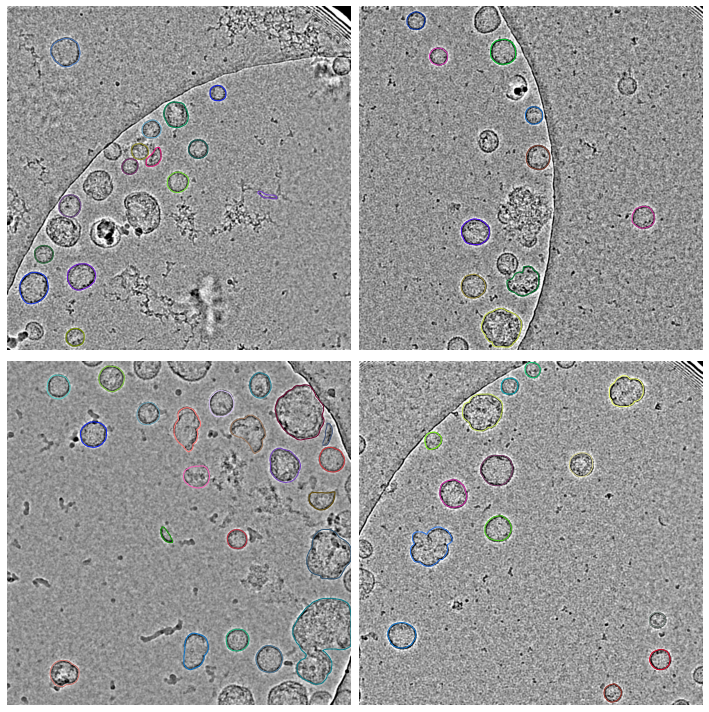

In [12]:
#Get all image files
image_dir = "yolo_dataset/train/images/"
annotation_dir = "yolo_dataset/train/labels/"
all_image_files = [f for f in os.listdir(image_dir) if f.endswith('.tif')]
random_image_files = random.sample(all_image_files, 4)

# Get corresponding annotation files
image_paths = [os.path.join(image_dir, f) for f in random_image_files]
annotation_paths = [os.path.join(annotation_dir, f.replace(".tif", ".txt")) for f in random_image_files]
utils.display_images_with_annotations(image_paths, annotation_paths)

In [ ]:
model = YOLO("/home/kamenan/Documents/Stage Dev Deep Learning/ultralytics/ultralytics/cfg/models/v8/yolov8-seg.yaml") # build a new model from yaml
model = YOLO("yolov8m-seg.pt") # transfer weights fro a pre-trained model (recommended for training)

In [ ]:
with open('yolo_dataset/data.yaml', 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [ ]:
multi_class = "yolo_dataset/results"
name = "125_epochs_seg_tune_focalLoss"

In [ ]:
%load_ext tensorboard
%tensorboard --logdir HOME


In [ ]:
# Train the model
#results = model.train(data='yolo_dataset/data.yaml',
#                    project=multi_class,
#                    name=name,
#                    epochs=125,
#                    lr0=0.0001
#                    )
     

In [ ]:
def convert_images_from_32bits(directory: str) -> None:
    """
    Convert all 32-bit images in a specified directory to 16-bit format, regardless of the image format.
    
    This function iterates through all files in the given directory and checks if they are images (regardless of format).
    If an image is in 32-bit mode (either 'I' for integer or 'F' for floating point), it converts the image to 16-bit format ('I;16B')
    and saves the converted image back to the same location, replacing the original file.

    Args:
        directory (str): The directory containing the images to be converted.

    Returns:
        None: The function performs the conversion and saves the results in place.

    Supported image formats:
        The function supports common image formats such as .png, .jpg, .jpeg, .tiff, .tif, .bmp, etc.

    Example:
        If the directory contains 32-bit images, they will be converted to 16-bit and saved with the same name.

    Notes:
        - This function uses the Python Imaging Library (PIL) to handle image conversion.
        - The conversion replaces the original 32-bit image file.
    """
    
    # Supported image file formats
    valid_extensions = ('.png', '.jpg', '.jpeg', '.tiff', '.tif', '.bmp', '.gif')

    # Iterate over all the files in the directory
    for filename in os.listdir(directory):
        if filename.lower().endswith(valid_extensions):
            file_path = os.path.join(directory, filename)
            
            # Open the image
            with Image.open(file_path) as img:
                # Check if the image is in 32-bit mode
                if img.mode == 'I' or img.mode == 'F':
                    # Convert the image to 16-bit
                    img_16bit = img.convert('I;16B')
                    
                    # Save the converted image, replacing the original file
                    img_16bit.save(file_path)
                    print(f"Converted {file_path} to 16-bit.")


In [ ]:

def convert_images_to_16bit(directory):
    # Parcours tous les fichiers du répertoire
    for filename in os.listdir(directory):
        if filename.lower().endswith(('.tif')):
            file_path = os.path.join(directory, filename)
            
            # Ouvre l'image
            with Image.open(file_path) as img:
                # Vérifie si l'image est en 32 bits
                if img.mode == 'I' or img.mode == 'F':
                    # Convertit l'image en 16 bits
                    img_16bit = img.convert('I;16B')
                    
                    # Sauvegarde l'image convertie, remplaçant l'original
                    img_16bit.save(file_path)
                    print(f"Converted {file_path} to 16-bit.")



### Hyperparameter tuning

In [ ]:
# Hyperparameters space
space = {  # key: (min, max, gain(optional))
            #"optimizer": ('SGD', 'Adam', 'AdamW', 'NAdam', 'RAdam', 'RMSProp'),
            "lr0": (1e-3, 1e-2),  # initial learning rate (i.e. SGD=1E-2, Adam=1E-3)
            "lrf": (0.0001, 0.1),  # final OneCycleLR learning rate (lr0 * lrf)
            "momentum": (0.7, 0.98, 0.3),  # SGD momentum/Adam beta1
            "weight_decay": (0.0, 0.001),  # optimizer weight decay 5e-4
            #"warmup_epochs": (0.0, 5.0),  # warmup epochs (fractions ok)
            #"warmup_momentum": (0.0, 0.95),  # warmup initial momentum
            #"box": (1.0, 20.0),  # box loss gain
            #"cls": (0.2, 4.0),  # cls loss gain (scale with pixels)
            "label_smoothing": (0.0, 1.0),
            #"dfl": (0.4, 6.0),  # dfl loss gain
            "hsv_h": (0.0, 0.1),  # image HSV-Hue augmentation (fraction)
            "hsv_s": (0.0, 0.9),  # image HSV-Saturation augmentation (fraction)
            "hsv_v": (0.0, 0.9),  # image HSV-Value augmentation (fraction)
            "degrees": (-180.0, 180.0),  # image rotation (+/- deg)
            "translate": (0.0, 1.0),  # image translation (+/- fraction)
            "scale": (0.0, 0.95),  # image scale (+/- gain)
            "shear": (-180.0, 180.0),  # image shear (+/- deg)
            #"perspective": (0.0, 0.001),  # image perspective (+/- fraction), range 0-0.001
            "flipud": (0.0, 1.0),  # image flip up-down (probability)
            "fliplr": (0.0, 1.0),  # image flip left-right (probability)
            #"bgr": (0.0, 1.0),  # image channel bgr (probability)
            "mosaic": (0.0, 1.0),  # image mixup (probability)
            "mixup": (0.0, 1.0),  # image mixup (probability)
            #"erasing": (0.0, 0.9),
            #"crop_fraction": (0., 1.0),
            #"copy_paste": (0.0, 1.0),  # segment copy-paste (probability)
        }

In [ ]:
from PIL import Image
model1 = YOLO("yolo_dataset/results/150_epochs_seg_tune/weights/best.pt")

image = "/home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/sanofi_domv/test_img/FoilHole_7474166_Data_7474929_7474930_20240308_1606.tif.tif"
#filename="yolo_dataset/results/125_epochs_seg_m_tune_best"
results = model1.predict(image, conf=0.7, show_labels=False, show_boxes=True, show=True)  #Adjust conf threshold
# Visualize the results
for i, r in enumerate(results):
    # Plot results image
    im_bgr = r.plot(masks=False, probs=False)  # BGR-order numpy array
    im_rgb = Image.fromarray(im_bgr[..., ::-1])  # RGB-order PIL image

    # Show results to screen (in supported environments)
    #r.show()

    # Save results to disk
   # r.save(filename=f"yolo_dataset/results/125_epochs_seg_m/200L_GBD_50K_029_seg.png")

In [ ]:
def evaluation(model, data_dir, ious):

    #ious = np.linspace(.5,1,50)
    precision = []
    recall = []
    jac_idx = []
    for io in ious:
        tp_eval = YOLO(model)
        metrics = tp_eval.val(data= data_dir,
                              iou=io,
                              device=0
                              )
        precision.append(metrics.results_dict["metrics/precision(B)"])
        recall.append(metrics.results_dict["metrics/recall(B)"])
        conf_mtrx = metrics.confusion_matrix
        j_idx = conf_mtrx.matrix[0][0]/conf_mtrx.matrix.sum()
        jac_idx.append(j_idx)
    return jac_idx, precision, recall

In [ ]:
jac_idx, precision, recall = evaluation(model="yolo_dataset/results/125_epochs_seg_l2/weights/best.pt", data_dir="yolo_dataset/data.yaml", ious=np.linspace(.5,1,50))


In [ ]:
model1 = YOLO("yolo_dataset/results/125_epochs_seg_l2/weights/best.pt")

image = "/home/kamenan/Documents/Stage Dev Deep Learning/YOLOV8 evaluation/sanofi_test/test_img/200L_GBD_50K_029.dm3.tif.tif"

results = model1.predict(image, conf=0.5, show_labels=True, show_boxes=True, show=True)  #Adjust conf threshold

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Sample confusion matrix array
confusion_matrix = np.array([[0, 0, 0, 0],
                             [1, 9, 1,0],
                             [0, 0, 10, 0],
                             [5, 3, 2, 0]])

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, class_names):
    """
    Plots a confusion matrix using Seaborn heatmap.
    
    Args:
        cm (array): Confusion matrix array
        class_names (list): List of class names
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

# List of class names
class_names = ['Arch', 'Blackberry', 'Round', 'Background']

# Plotting the confusion matrix
plot_confusion_matrix(confusion_matrix, class_names)